## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [68]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

In [69]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [71]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
1425,It honestly felt like someone punched a hole r...,1
1222,"Participation takes approximately 5 minutes, h...",0
2413,"That being said, I love her when she is good, ...",0
2555,"Hi there, I'm a 21 year old Scottish student s...",0
2682,And he said that he had some deep feelings for...,1


In [72]:
df['label'].unique()

array([1, 0], dtype=int64)

In [73]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

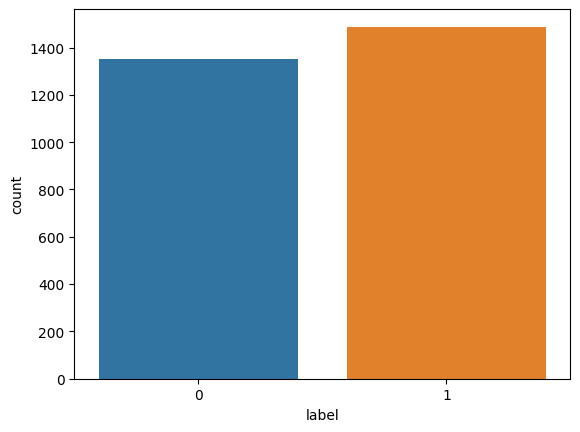

In [74]:
sns.countplot(x='label', data=df)

In [75]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
659,there is a waitlist to be called when they bec...,0
2578,its hard to find doctors that take cash within...,0
809,"days where it is really good, and days where y...",0
2509,i got a new job !! yay but there will not be ...,0
785,it sucks. i know i need help. i want to get he...,1


In [76]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
2236,so besides my dad my entire family is toxic to...,0
2800,i'm and i'll be leaving home for the first ti...,0
1617,havnt had one in years after it was done i cou...,1
2184,friends privy to the situation believe that sh...,1
1808,i'm scared to start the eviction process but i...,1
67,i know this may seem like a small thing but to...,1
712,she has a history of being extremely over the ...,1
597,the first veteran to participate in the study ...,0
720,well not big but petty look i live around the ...,0
122,i cant take video of him due to the lights aim...,0


In [77]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 330.3 kB/s eta 0:02:10
     --------------------------------------- 0.0/42.8 MB 325.1 kB/s eta 0:02:12
     --------------------------------------- 0.1/42.8 MB 465.5 kB/s eta 0:01:32
     --------------------------------------- 0.1/42.8 MB 714.4 kB/s eta 0:01:00
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:31
      --------------------------------------- 0.5/42.8 MB 2.0 MB/s eta 0:00:22
      --------------------------------------- 1.0/42.8 MB 3.3 MB/s eta 0:00:13
     - -------------------------------------- 2.0/42.8 MB 5.9 MB/s eta 0:00:07
     -- ------------------------------------- 2.6/42.8 MB 6.7 MB/s eta 0:00:07
     ---- ----------------------------------- 4.5/42.8 MB 9.9 MB/s eta 0:00:04
     ------ --------------------------------- 6.5/42.8 MB 13.0 MB/s eta 0:00:03
     -------- ------------------------------- 9.4/42.8

In [78]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
nlp.Defaults.stop_words

In [79]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
154,wonder like gotten help earlier here's use inp...,1
2586,chill let contact tldr level communication out...,1
2405,able quickly isnt simple fix anymore roofer co...,1
2664,certainly hadhas ability worstbest story prick...,1
710,survived years physical sexual abuse kid i'm f...,1
1125,enjoy don't want break silly think i'm making ...,1
1177,days start try plans hang eat hour ends saying...,1
1613,i've started having flashbacks tearfulness int...,1
1487,start ptsd years emotionalmentalverbal abuse y...,1
810,i'm exaggerating legitimately thought going di...,1


In [80]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [81]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:18<00:00, 155.65it/s]


,text,label
271,sweet welcoming feel overwhelmed feel give ind...,1
737,guy pull say cop way give ride parking lot cop...,0
555,lot common like go country christmas holiday g...,0
1562,I have homeless couple day roommate completely...,1
29,headache load headache time I m hate bad brain...,1
866,fun fact help bit year ago twitter check tweet...,0
1525,mind control do not feel try away like I m dru...,1
655,result total burn month ago situation abuser c...,1
2714,online friend let us jim jehovah 's witness I ...,0
1988,feel like trust truly feel feel sort platonic ...,1


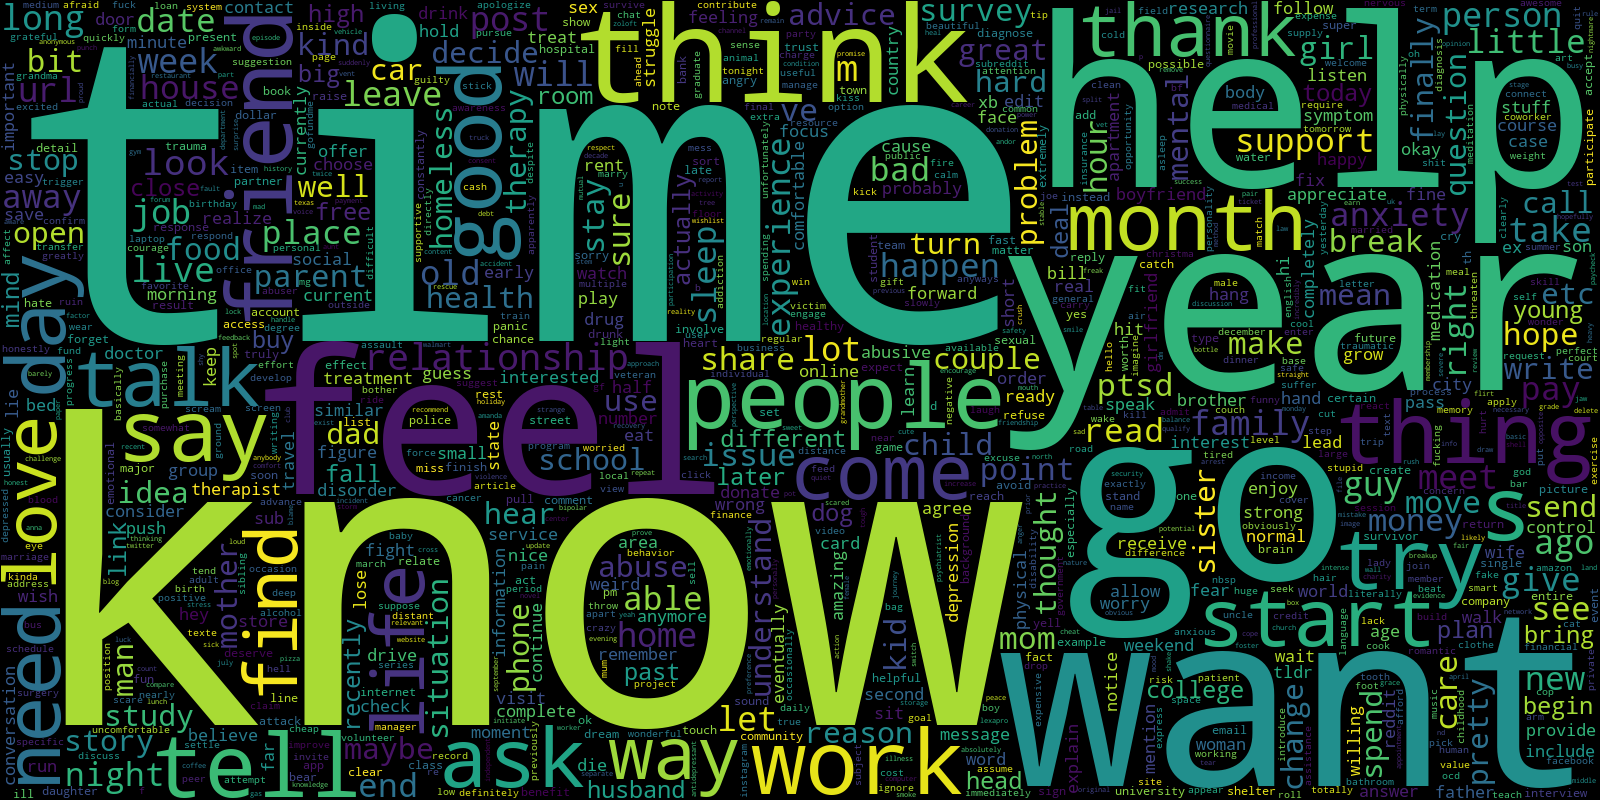

In [82]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

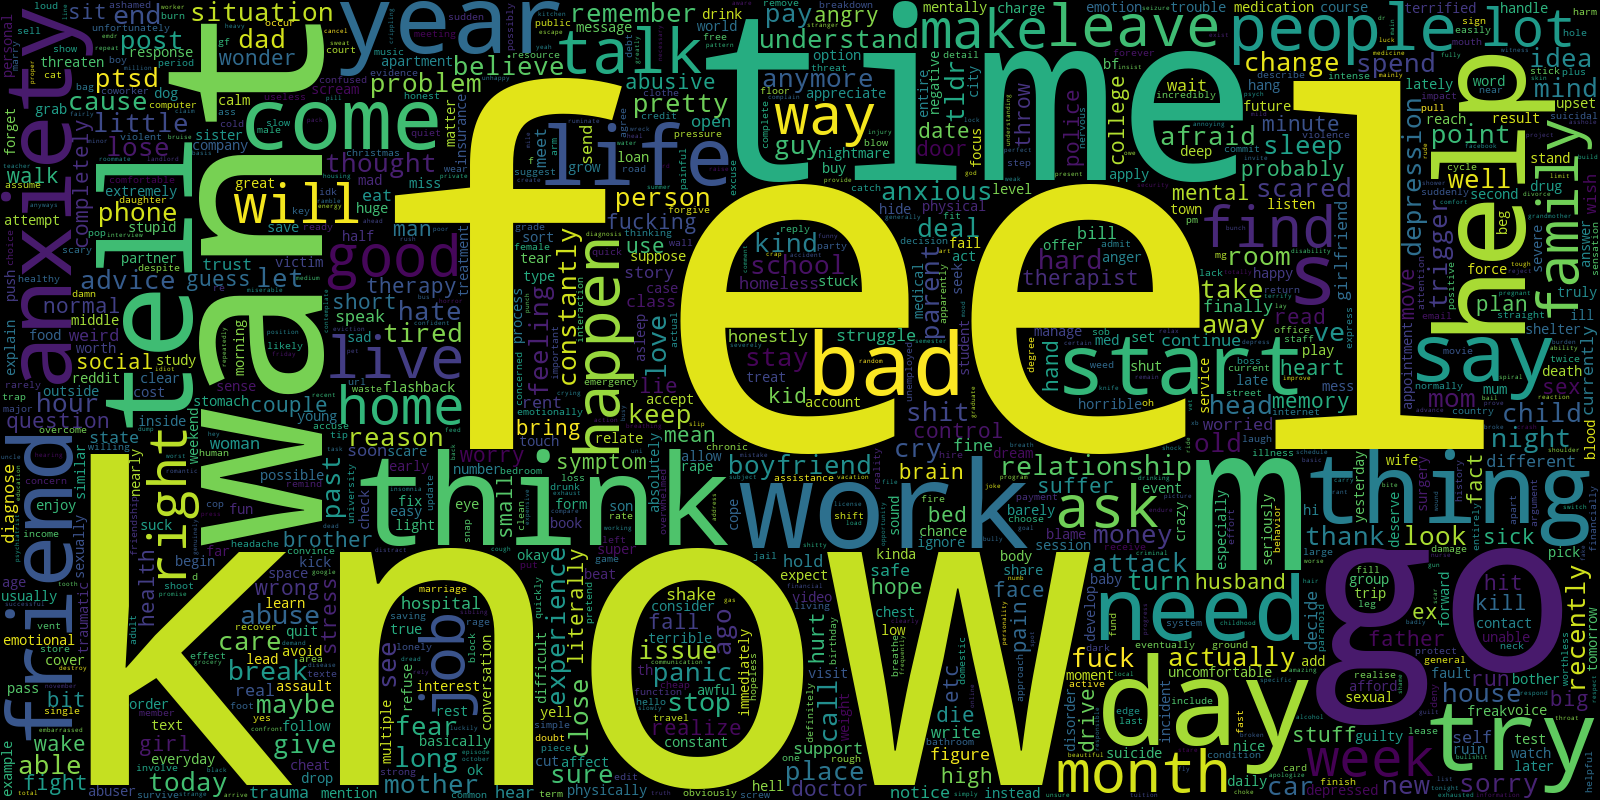

In [83]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN <---
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.1, stratify= df['label'])

In [44]:
X_train.shape,y_train.shape

((2536,), (2536,))

In [45]:
X_val.shape,y_val.shape

((282,), (282,))

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [59]:
len(vectorizer.get_feature_names_out())

72867

In [60]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)

In [52]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.tolist())

X_train_tokens = tokenizer.texts_to_sequences(X_train.tolist())
X_val_tokens = tokenizer.texts_to_sequences(X_val.tolist())

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_tokens)

X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_val_tokens = pad_sequences(X_val_tokens, maxlen=max_len, padding='post')


In [53]:
X_train_tokens

array([[ 755,   53,    3, ...,    0,    0,    0],
       [  14,  136,  260, ...,    0,    0,    0],
       [   7,   24,  439, ...,    0,    0,    0],
       ...,
       [  73, 2150,   79, ...,    0,    0,    0],
       [ 565,  708,  363, ...,    0,    0,    0],
       [ 149,   38,    2, ...,    0,    0,    0]])

Sieć Rekurencyjna (LSTM/GRU/sieć dwukierunkowa) inna niż podstawowe RNN

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

embedding_dim = 50

model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, trainable=False))
model_1.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model_1.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model_1.add(Dense(units = 32 , activation = 'relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 143, 50)           429500    
                                                                 
 lstm_8 (LSTM)               (None, 143, 128)          91648     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 572,669
Trainable params: 143,169
Non-trainable params: 429,500
_________________________________________________________________


In [65]:
model_lstm = model_1.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 143), found shape=(None, 72867)


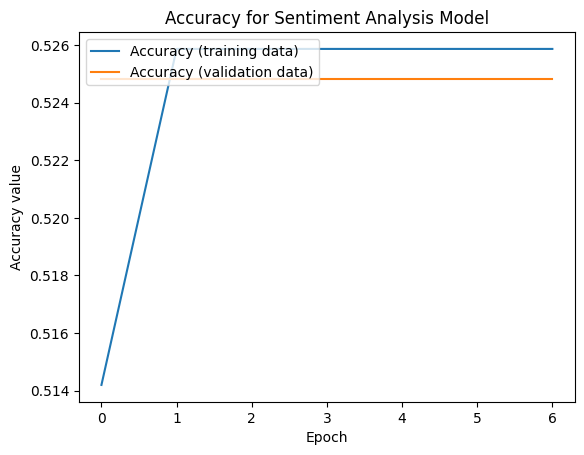

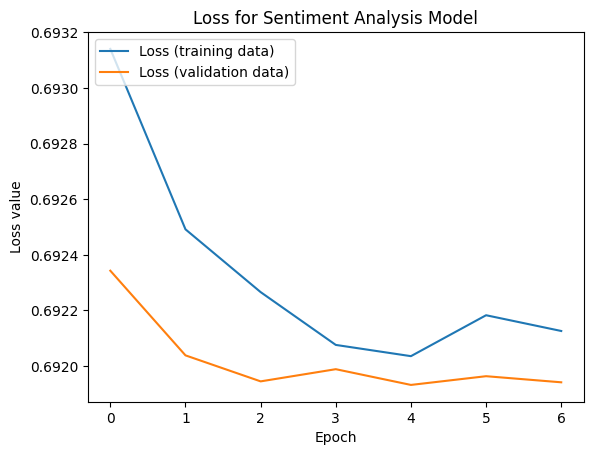

In [22]:
import matplotlib.pyplot as plt

plt.plot(model_lstm.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_lstm.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_lstm.history['loss'], label='Loss (training data)')
plt.plot(model_lstm.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [ ]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

    return sentence

In [ ]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence"
    else:
        return "All good don't sense ANY STRESS in here "

Wykorzystanie sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN

In [ ]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_1, sentence)
print(result)

1/1 [==============================] - 0s 477ms/step
I can sense STRESS in this sentence
